In [1]:
from keras import models, optimizers, losses
from keras import backend as K
from keras.utils import Progbar
from utils import *
from network import *
from matplotlib import pyplot as plt
import cv2

Using TensorFlow backend.


In [2]:
def plot_fn(pred, label):
    plt.figure(figsize=(16, 10))
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.xlabel("%f"%(pred[0,...,i].max()))
        plt.imshow(pred[0,...,i], cmap='gray', vmin = 0, vmax = label.max())
        plt.subplot(2, 6, i+1+6)
        plt.title("%f"%(label[0,...,i].max()))
        plt.imshow(label[0,...,i], cmap='gray', vmin = 0, vmax = label.max())
    plt.show()

In [3]:
G = generator(model='mobile', case=2)

print("\n===================================\n")

D = discriminator(model='mobile', case=1)

=========== Information about Backbone ===========
Loading MobileNet model
Total Parameter of Model :  3,228,864
Trainable Parameter of Model :  3,206,976
Non-Trainable Parameter of Model :  21,888

=========== Information about Whole Network ===========
Total Parameter of Model :  22,071,814
Trainable Parameter of Model :  22,049,926
Non-Trainable Parameter of Model :  21,888


=========== Information about Backbone ===========
Loading MobileNet model


C:\Users\user\Anaconda3\lib\site-packages\keras_applications\imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 6 input channels.
  str(input_shape[-1]) + ' input channels.')


Total Parameter of Model :  3,229,728
Trainable Parameter of Model :  3,207,840
Non-Trainable Parameter of Model :  21,888

=========== Information about Whole Network ===========
Total Parameter of Model :  12,668,961
Trainable Parameter of Model :  12,647,073
Non-Trainable Parameter of Model :  21,888


In [4]:
def Gen2Dis(gen, dis, case=1):
    if case==2:
        dis_out, texture = dis(gen.output)
        net = models.Model(inputs=gen.input, outputs=[gen.output, dis_out])
    elif case==3:
        dis_out = dis(gen.output)
        net = models.Model(inputs=gen.input, outputs=[gen.output, dis_out])
    else:
        dis_out = dis(gen.output[0])
        net = models.Model(inputs=gen.input, outputs=[gen.output[0], dis_out])
    
    return net

In [5]:
D.trainable=False
A = Gen2Dis(G, D, case=3)
A.compile(optimizer=optimizers.Adam(lr=0.0001, epsilon=1e-8), loss=[losses.mean_squared_error, losses.binary_crossentropy], loss_weights=[50, 1])

D.trainable=True
D.compile(optimizer=optimizers.Adam(lr=0.0001, epsilon=1e-8), loss=losses.binary_crossentropy)

In [6]:
train_low, train_high, val_low, val_high, test_low = data_loader_v2('../MRI Enhancing/4gan_m')
print("Train X's shape : ", train_low.shape)
print("Train Y's shape : ", train_high.shape)
print("Validation X's shape : ", val_low.shape)
print("Validation Y's shape : ", val_high.shape)
print("Test X's shape : ", test_low.shape)

Train X's shape :  (303, 320, 256, 3)
Train Y's shape :  (303, 320, 256, 6)
Validation X's shape :  (25, 320, 256, 3)
Validation Y's shape :  (25, 320, 256, 6)
Test X's shape :  (328, 320, 256, 3)


In [7]:
shuffle_idx = np.random.choice(len(train_low), len(train_low), replace=False)
train_low = train_low[shuffle_idx]
train_high = train_high[shuffle_idx]
batch = 16
steps = len(train_low)//batch +1

 150/1500 [==>...........................] - ETA: 2:55:17 - G_Style: 556835.9214 - G_Dis: 11136.5811 - D_Dis: 0.00261217.0595283495884


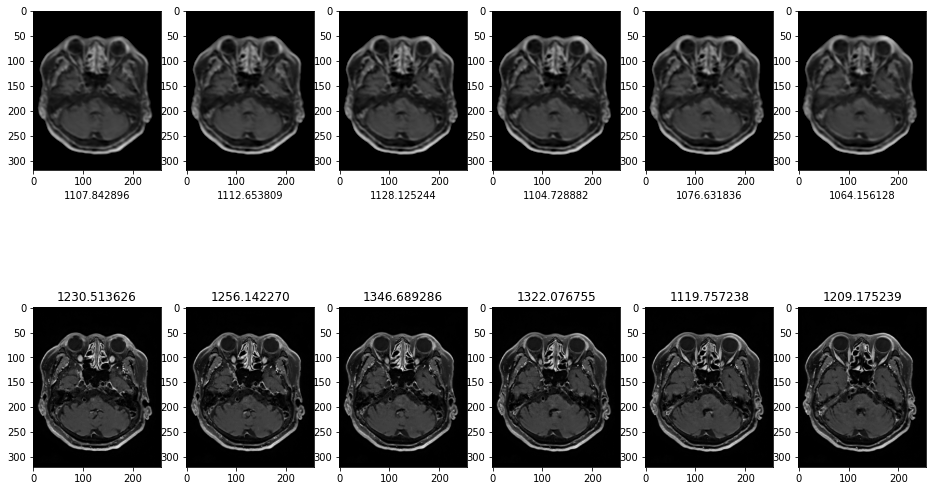

 300/1500 [=====>........................] - ETA: 2:33:39 - G_Style: 339107.4322 - G_Dis: 6781.9921 - D_Dis: 0.0024925.7996729463339


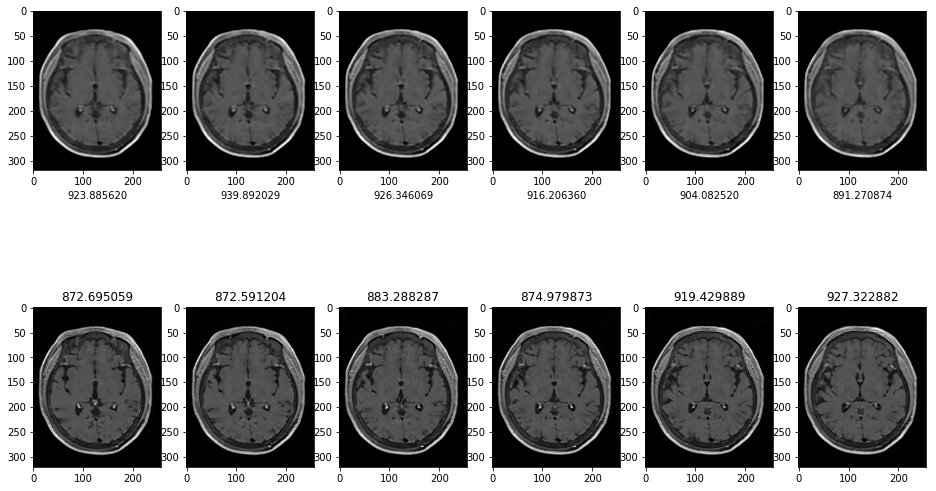

 450/1500 [========>.....................] - ETA: 2:13:50 - G_Style: 255768.9056 - G_Dis: 5115.2146 - D_Dis: 0.00161048.230861409257


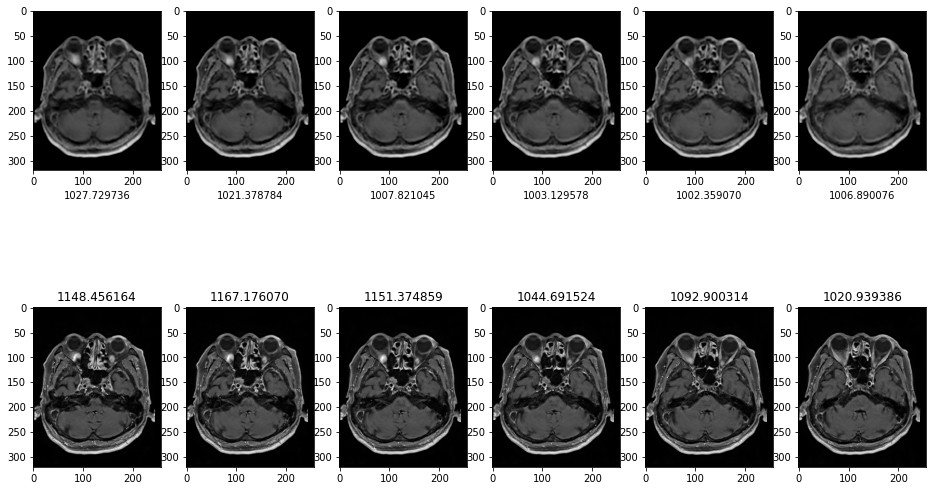

 600/1500 [===========>..................] - ETA: 1:54:19 - G_Style: 209549.8991 - G_Dis: 4190.8339 - D_Dis: 0.00221135.911835450679


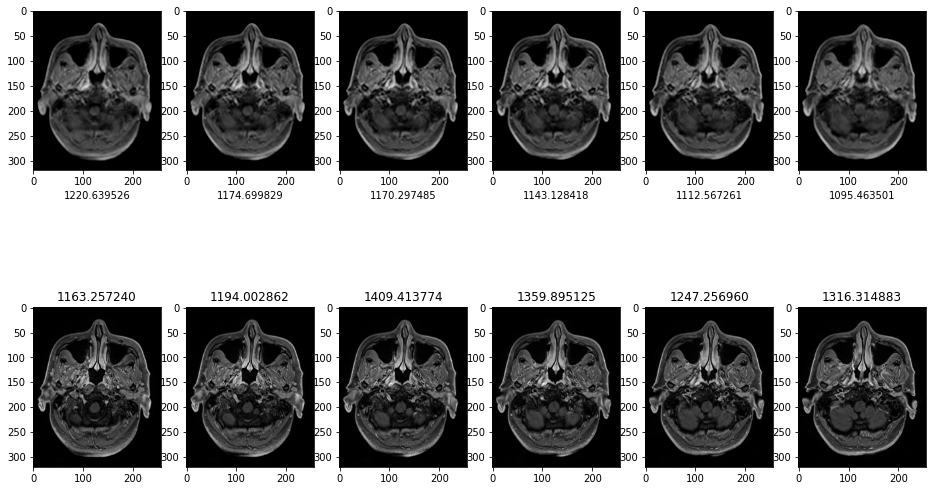

 750/1500 [==============>...............] - ETA: 1:35:10 - G_Style: 179564.1083 - G_Dis: 3591.1246 - D_Dis: 0.00181323.1734677702188


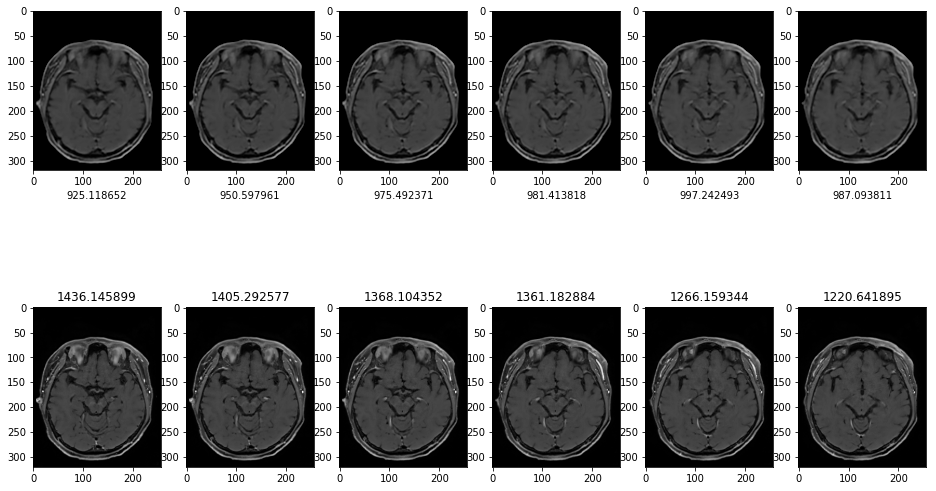

 900/1500 [=================>............] - ETA: 1:16:06 - G_Style: 157908.8622 - G_Dis: 3158.0252 - D_Dis: 0.00151001.2969037157794


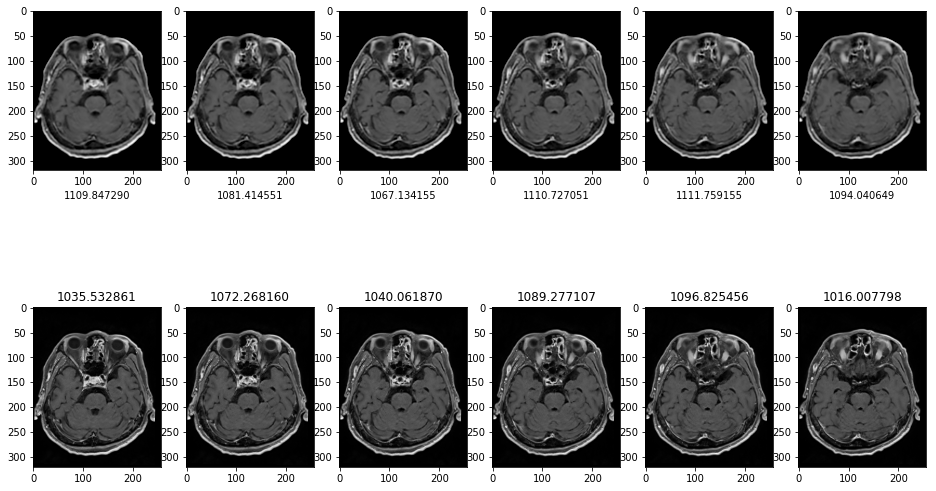

1050/1500 [====================>.........] - ETA: 56:59 - G_Style: 141898.7755 - G_Dis: 2837.8282 - D_Dis: 0.00131216.20940770333


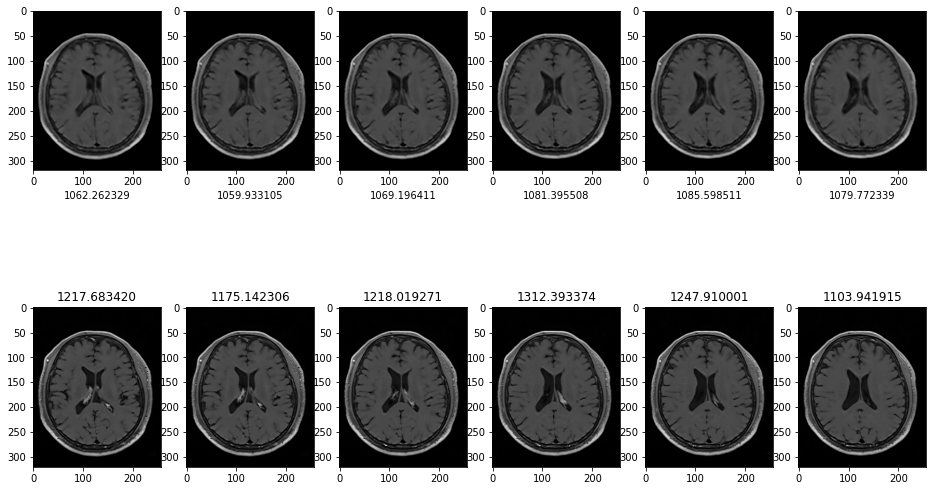

1200/1500 [=======================>......] - ETA: 37:56 - G_Style: 129161.3284 - G_Dis: 2583.0814 - D_Dis: 0.00141269.2833641916513


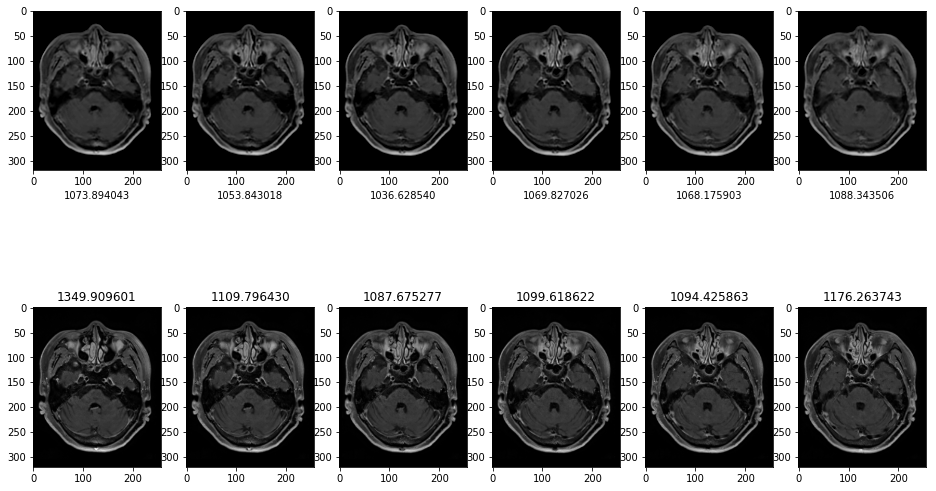

1350/1500 [==========================>...] - ETA: 18:58 - G_Style: 118812.0790 - G_Dis: 2376.0974 - D_Dis: 0.00131135.911835450679


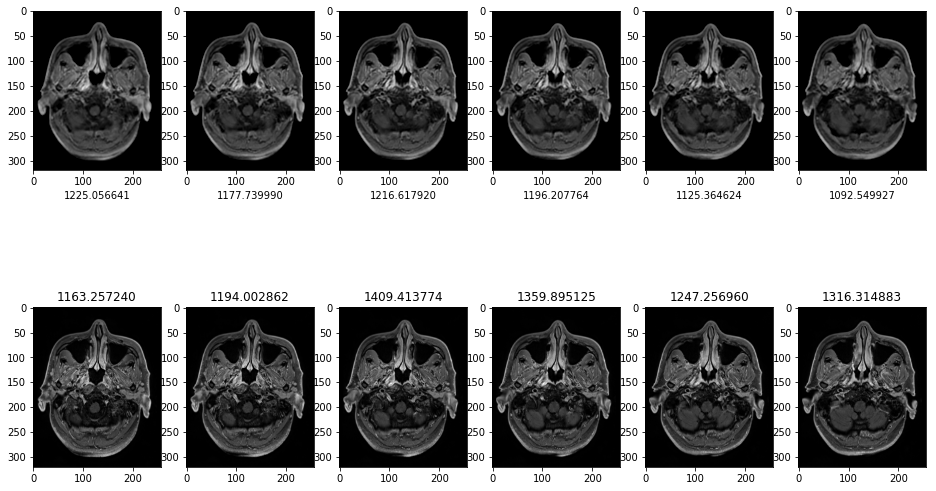

1500/1500 [==============================] - 11369s 8s/step - G_Style: 110176.4597 - G_Dis: 2203.3852 - D_Dis: 0.0011
1137.8512155972421


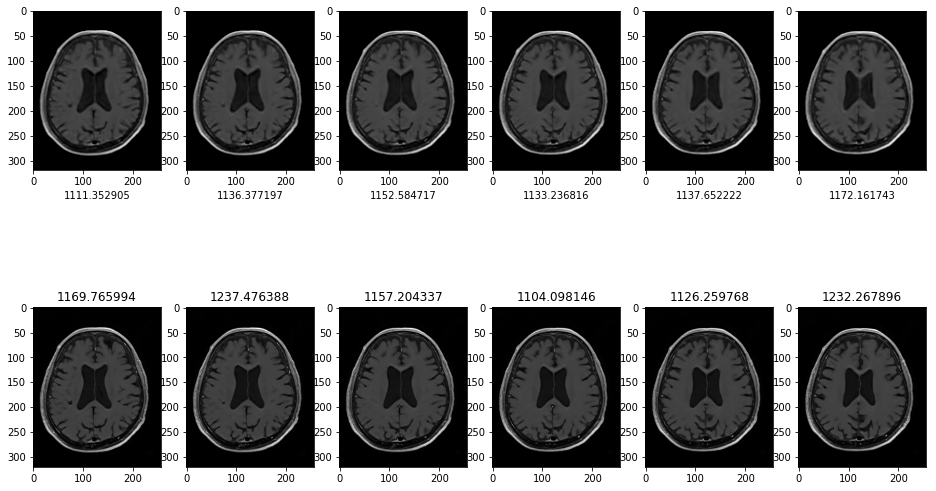

In [8]:
epochs = 1500
total_progbar = Progbar(epochs)
for epoch in range(epochs):
    #print("Epochs : %03d/%03d"%(epoch+1, epochs))
    epoch_g_style = 0
    epoch_g_dis = 0
    epoch_d_dis = 0
#     epoch_progbar = Progbar(steps)
    for step in range(steps):
        
        idx = step*batch
        
        if step+1 == steps:
            step_train_low = train_low[idx:]
            step_train_high = train_high[idx:]
        else:
            step_train_low = train_low[idx:idx+4]
            step_train_high = train_high[idx:idx+4]
            
        train_gen_label = np.ones([len(step_train_low), 1], dtype='float')
        train_dis_label = np.zeros([len(step_train_low)*2, 1])
        train_dis_label[len(step_train_low):] = 1.
        
        D.trainable=False
        
        G_Loss = A.train_on_batch(step_train_low, [step_train_high, train_gen_label])
        G_output, _= A.predict(step_train_low)
        
        D.trainable=True
        train_dis_input = np.concatenate([step_train_high, G_output], 0)
        D_Loss = D.train_on_batch(train_dis_input, train_dis_label)
        
        epoch_g_style += G_Loss[0]
        epoch_g_dis +=G_Loss[1]
        
        epoch_d_dis +=D_Loss
        
    total_progbar.update(epoch+1, [("G_Style",epoch_g_style/steps), ("G_Dis", epoch_g_dis/steps), ("D_Dis", epoch_d_dis/steps)])    
    if (epoch+1)%100 == 0:
        A.save('./checkpoint/mobile/%04d_%.2f.h5'%(epoch+1, epoch_g_style/steps))
    if (epoch+1)%150 == 0:
        ran_idx = np.random.choice(len(train_low)-1, 1)
        test_in = train_low[ran_idx[0]:ran_idx[0]+1]
        test, _ = A.predict(test_in)
        print(test_in.max())

        plot_fn(test, train_high[ran_idx[0]:ran_idx[0]+1])
    #total_progbar.update(epoch+1, [("G_Style", epoch_g_style/steps), ("G_Texture", epoch_g_texture/steps), ("G_Dis", epoch_g_dis/steps), ("D_Texture", epoch_d_texture/steps), ("D_Dis", epoch_d_dis/steps)])